In [24]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import sys
sys.path.append('data_square/')
import generate_data
import pickle

In [4]:
# data = generate_data.load_data("data_ising_square_largeL.pkl")
data = pickle.load(open('data_square/data_ising_square_largeL.pkl','rb'))

In [5]:
data.keys()

dict_keys([16, 128, 32, 8, 64, 'Ls', 256])

In [6]:
data['Ls']

[8, 16, 32, 64, 128, 256]

In [7]:
data_L_8 = data[8]
data_L_8.keys()
E = data_L_8['E']
obs_keys = data_L_8['observables']
print(obs_keys)

['E', 'C', 'M', 'absM', 'chi', 'UB']


## a)

In [8]:
def plot_observable(obs='E'):
    plt.figure()
    for L in data['Ls']:
        data_L = data[L]
        Ts = data_L['Ts']
        E = data_L[obs]
        plt.errorbar(Ts, E[:, 0], E[:, 1], label="L = {L:d}".format(L=L))
    plt.ylabel(obs)
    plt.xlabel("T")
    plt.legend()
    plt.show()

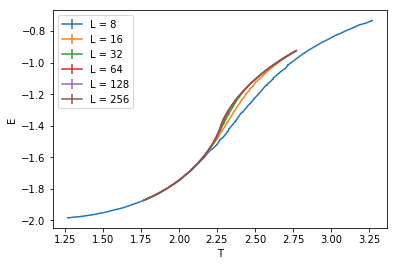

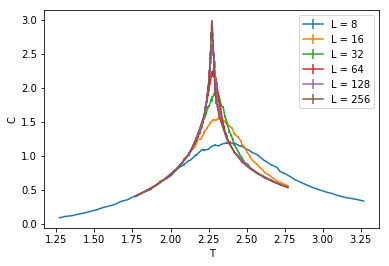

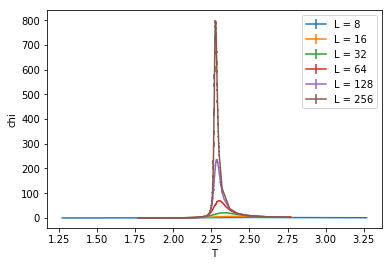

In [9]:
plot_observable('E')
plot_observable('C')
plot_observable('chi')

## b) Determine Tc by specific heat and magnetic susceptibility

estimate with np.argmax from chi: T_c ~= 2.26642095644


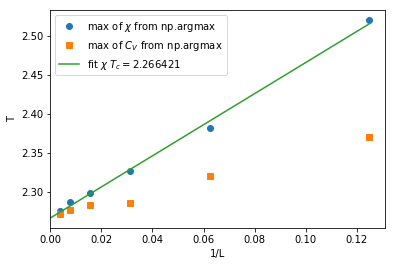

NB: The fit function T_{max} = T_c + const/L is justified a posteriory by the scaling collapse with nu = 1.
In general T_{max} = T_c + const / L^{\nu} + subleading terms.


In [11]:
Ls = np.array(data['Ls'])
T_max_chi = []
T_max_C = []
for L in Ls:
    data_L = data[L]
    Ts = data_L['Ts']
    chi = data_L['chi'][:, 0]
    index_max_chi = np.argmax(chi)
    T_max_chi.append(Ts[index_max_chi])
    C = data_L['C'][:, 0]
    index_max_C = np.argmax(C)
    T_max_C.append(Ts[index_max_C])

plt.figure()
plt.plot(1./Ls, T_max_chi, 'o', label='max of $\\chi$ from np.argmax')
plt.plot(1./Ls, T_max_C, 's', label='max of $C_V$ from np.argmax')

# fit a straight line to the T_max_chi vs 1/L values
fit_coeff = np.polyfit(1./Ls, T_max_chi, 1)
Tc = fit_coeff[-1]
plt.plot([0, 1./8], np.polyval(fit_coeff, [0, 1./8]), label=r'fit $\chi$ $T_c = {Tc:f}$'.format(Tc=Tc))
print("estimate with np.argmax from chi: T_c ~=", fit_coeff[-1])


plt.xlabel('1/L')
plt.ylabel('T')
plt.xlim(0.)
plt.legend()
plt.show()

print("NB: The fit function T_{max} = T_c + const/L is justified a posteriory by the scaling collapse with nu = 1.")
print("In general T_{max} = T_c + const / L^{\\nu} + subleading terms.")

Since the data is noisy, it is better to extract the maximum by fitting a parabola instead of just using np.argmax.
estimated this way from C: T_c ~= 2.2685775914694193 , not too bad :)


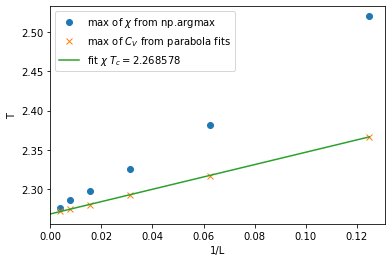

In [9]:
print("Since the data is noisy, it is better to extract the maximum by fitting a parabola instead of just using np.argmax.")
T_max_C_parabola = []
for L in Ls:
    data_L = data[L]
    Ts = data_L['Ts']
    chi = data_L['C'][:, 0]
    index_max_C = np.argmax(C)
    # use 20 values around the guess from argmax
    # (the data set has more points close to Tc )
    Ts_fit_parabola = Ts[index_max_C-10 : index_max_C+10]
    C_fit_parabola = data_L['C'][index_max_C-10 : index_max_C+10]
    fit_coeff_parabola = np.polyfit(Ts_fit_parabola, C_fit_parabola[:, 0], 2)
    # fit_coeff = a , b, c, such that the fit = a T**2 + b T + c
    # -> maxima = -b / 2 a
    T_max_C_parabola.append(-fit_coeff_parabola[1] / 2/fit_coeff_parabola[0])

# replot 
plt.figure()
plt.plot(1./Ls, T_max_chi, 'o', label='max of $\\chi$ from np.argmax')
plt.plot(1./Ls, T_max_C_parabola, 'x', label='max of $C_V$ from parabola fits')

# fit a straight line to the T_max_chi vs 1/L values
fit_coeff_chi = np.polyfit(1./Ls, T_max_C_parabola, 1)
Tc = fit_coeff_chi[-1]
plt.plot([0, 1./8], np.polyval(fit_coeff_chi, [0, 1./8]), label=r'fit $\chi$ $T_c = {Tc:f}$'.format(Tc=Tc))
print("estimated this way from C: T_c ~=", fit_coeff_chi[-1], ", not too bad :)")
Tc = fit_coeff_chi[-1]

plt.xlabel('1/L')
plt.ylabel('T')
plt.xlim(0.)
plt.legend()
plt.show()

## c) Determine Tc by Binder cumulant

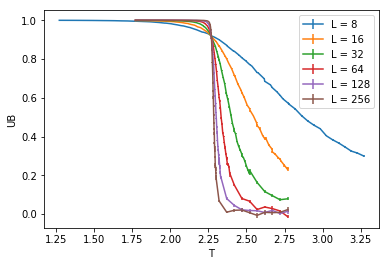

In [12]:
plot_observable('UB')

In [13]:
# extract crossing points
print("NB: again, to extract the crossing points, it's best to fit lines to the data")
lines_fit_coeff = {} # dictionary: L -> fit_coeff
for L in data['Ls']:
    # fit a line to 6 points close to the guess of Tc
    data_L = data[L]
    index_close = np.argmin(np.abs(Ts-Tc))
    Ts_fit = data_L['Ts'][index_close-2 : index_close+4] 
    Ub_fit = data_L['UB'][index_close-2 : index_close+4, 0]
    fit_coeff = np.polyfit(Ts_fit, Ub_fit, 1)
    lines_fit_coeff[L] = fit_coeff

crossings_2L = []
crossings_4L = []
# We are looking for a solution of:
# a*x+b=c*x+d
#x=-(b-d)/(a-c)
for L in data['Ls']:
    if 2*L in lines_fit_coeff:
        fit_L = lines_fit_coeff[L]
        fit_2L = lines_fit_coeff[2*L]
        diff = fit_L - fit_2L #[a,b]-[c,d]=[a-c,b-d]
        crossing = -diff[1]/diff[0]
        print("crossing", L, "with", 2*L, "at T = ", crossing)
        crossings_2L.append(crossing)
    if 4*L in lines_fit_coeff:
        fit_L = lines_fit_coeff[L]
        fit_4L = lines_fit_coeff[4*L]
        diff = fit_L - fit_4L
        crossing = -diff[1]/diff[0]
        print("crossing", L, "with", 4*L, "at T = ", crossing)
        crossings_4L.append(crossing)
        
print("mean of the crossings L with 2L:", np.mean(crossings_2L))
print("mean of the crossings L with 4L:", np.mean(crossings_4L))
print("For comparison: Tc_exact = ", 2. / np.log(1. + np.sqrt(2)))
Tc = np.mean(crossings_4L)

NB: again, to extract the crossing points, it's best to fit lines to the data
crossing 8 with 16 at T =  2.27105724177
crossing 8 with 32 at T =  2.26640582767
crossing 16 with 32 at T =  2.26423910986
crossing 16 with 64 at T =  2.2674813895
crossing 32 with 64 at T =  2.26913736489
crossing 32 with 128 at T =  2.2684065076
crossing 64 with 128 at T =  2.26808433209
crossing 64 with 256 at T =  2.26879364791
crossing 128 with 256 at T =  2.26915193943
mean of the crossings L with 2L: 2.26833399761
mean of the crossings L with 4L: 2.26777184317
For comparison: Tc_exact =  2.26918531421


## d) Determine the critical exponents from specific heat and magnetic susceptibility

gamma : 1.76270819422
alpha : 0.260874573728


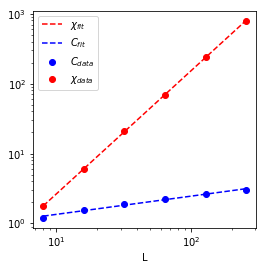

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))

C_max_list = []
chi_max_list = []

for L in data['Ls']:
    Ts = data[L]['Ts']
    C_array = data[L]['C']
    chi_array = data[L]['chi']
    C_max_list.append(np.amax(C_array))
    chi_max_list.append(np.amax(chi_array))

x_data = np.array(data['Ls']) 

fit_order = 1
coeff  = np.polyfit(np.log(x_data), np.log(np.array(chi_max_list)), fit_order)
# Power law: C=a*x^b
# log(C)=log(a)+b*log(x)
poly = np.poly1d(coeff)
x_interp = np.linspace(np.amin(x_data),np.amax(x_data),50)
y_interp = np.exp(poly(np.log(x_interp)))
# Since log(C)=a*log(x)+b
# C=exp(a*log(x)+b)
ax.loglog(x_interp, y_interp, 'r--', label='$\chi_{fit}$')
print("gamma :", coeff[0])

coeff  = np.polyfit(np.log(x_data), np.log(np.array(C_max_list)), fit_order)
poly = np.poly1d(coeff)
x_interp = np.linspace(np.amin(x_data),np.amax(x_data),50)
y_interp = np.exp(poly(np.log(x_interp)))
ax.loglog(x_interp, y_interp, 'b--', label='$C_{fit}$')
print("alpha :", coeff[0])


ax.loglog(x_data, C_max_list, 'bo', label='$C_{data}$')
ax.loglog(x_data, chi_max_list, 'ro', label='$\chi_{data}$')
ax.set_xlabel('L')
ax.legend()
    


The result for alpha is actually incorrect as we will see in f.).
One reason the plot above looks ok is because of we did not zoom in.
If one see closely, one will find it does not look linear in log-log plot.
In fact, the correct scaling is given by the semilogx plot over L.
That is the dependency of Cv is ~ log(L)



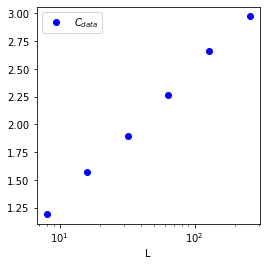

In [13]:
print("""
The result for alpha is actually incorrect as we will see in f.).
One reason the plot above looks ok is because of we did not zoom in.
If one see closely, one will find it does not look linear in log-log plot.
In fact, the correct scaling is given by the semilogx plot over L.
That is the dependency of Cv is ~ log(L)
""")
      
fig, ax = plt.subplots(1, 1, figsize=(4, 4))

C_max_list = []
chi_max_list = []

for L in data['Ls']:
    Ts = data[L]['Ts']
    C_array = data[L]['C']
    chi_array = data[L]['chi']
    C_max_list.append(np.amax(C_array))
    chi_max_list.append(np.amax(chi_array))

x_data = np.array(data['Ls']) 

# ax.semilogx(x_data, chi_max_list, 'bo', label='$\chi_{data}$')
ax.semilogx(x_data, C_max_list, 'bo', label='$C_{data}$')
ax.set_xlabel('L')
ax.legend()
    

## e)  Data collapse for Binder cumulant

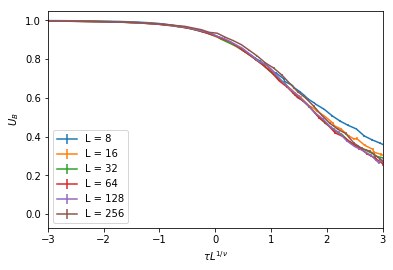

NB: The scaling collapse is only expected near the critical point.
Do not look at all the data, but zoom in to values close to tau = 0 (e.g. here -3:3 on the x-axis!)


In [26]:
# data collapse of UB
nu = 1.0

plt.figure()
for L in data['Ls']:
    data_L = data[L]
    Ts = data_L['Ts']
    UB = data_L['UB']
    tau = (Ts -Tc)/Tc
    tau_scaled = tau * L**(1./nu)
    plt.errorbar(tau_scaled, UB[:, 0], UB[:, 1], label="L = {L:d}".format(L=L))
plt.ylabel("$U_B$")
plt.xlabel("$\\tau  L^{1/\\nu}$")
plt.xlim(-3, 3)
plt.legend()
plt.show()

print("NB: The scaling collapse is only expected near the critical point.")
print("Do not look at all the data, but zoom in to values close to tau = 0 (e.g. here -3:3 on the x-axis!)")

## f)  Data collapse for specific heat and magnetic susceptibility

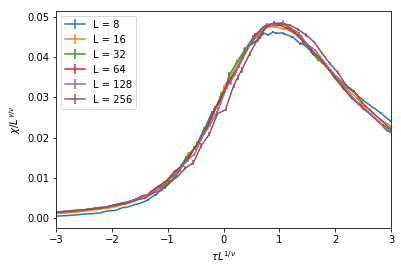

In [19]:
# data collapse of chi
gamma = 1.75

plt.figure()
for L in data['Ls']:
    data_L = data[L]
    Ts = data_L['Ts']
    chi = data_L['chi']
    tau = (Ts -Tc)/Tc
    tau_scaled = tau * L**(1./nu)
    chi_scaled = chi / L**(gamma / nu)
    plt.errorbar(tau_scaled, chi_scaled[:, 0], chi_scaled[:, 1], label="L = {L:d}".format(L=L))
plt.ylabel("$\\chi / L^{\\gamma/\\nu}$")
plt.xlabel("$\\tau  L^{1/\\nu}$")
plt.xlim(-3, 3)
plt.legend()
plt.show()
    

NB: since nu = 1, we formally get alpha = 0 from the hyperscaling relation d * nu= 2 - alpha.
Hence, C does not scale with a powerlaw, but with log(L).
Still, the collapse is worse, since subleading terms are more important...
That it has to scale as a logarithm can be seen on the right plot: 
    when L is doubled, C increases with a constant.  


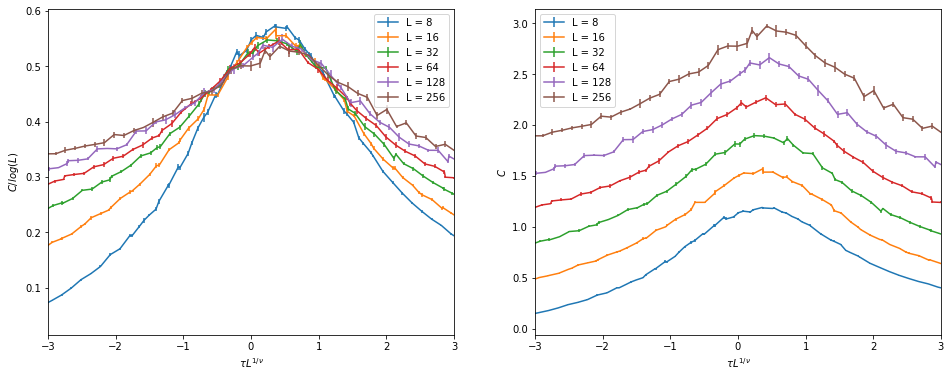

In [16]:
# data collapse of C
print("NB: since nu = 1, we formally get alpha = 0 from the hyperscaling relation d * nu= 2 - alpha.")
print("Hence, C does not scale with a powerlaw, but with log(L).")
print("Still, the collapse is worse, since subleading terms are more important...")
print("That it has to scale as a logarithm can be seen on the right plot: ")
print("    when L is doubled, C increases with a constant.  ")

fig,ax = plt.subplots(ncols=2,figsize=[16, 6])
for L in data['Ls']:
    data_L = data[L]
    Ts = data_L['Ts']
    C = data_L['C']
    tau = (Ts -Tc)/Tc
    tau_scaled = tau * L**(1./nu)
    C_scaled = C / np.log(L)
    ax[0].errorbar(tau_scaled, C_scaled[:, 0], C_scaled[:, 1], label="L = {L:d}".format(L=L))
    ax[1].errorbar(tau_scaled, C[:, 0], C[:, 1], label="L = {L:d}".format(L=L))
ax[0].set_ylabel("$C /log(L)$")
ax[0].legend()
ax[0].set_xlabel("$\\tau  L^{1/\\nu}$")
ax[1].set_ylabel("$C $")
ax[1].set_xlabel("$\\tau  L^{1/\\nu}$")
ax[1].legend()
ax[0].set_xlim(-3, 3)
ax[1].set_xlim(-3, 3)
plt.show()    

## g)  Triangular lattice

In [17]:
msg = """
For the triangular lattice, you just need to add the lines 
            m3 = xy_to_n((x+1) % Lx, (y+1) % Ly)
            bonds.append([n, m3])
to the function `init_system` in the file generate_data.py.
The critical temperature is different (Tc~= 3.64096), but the critical exponents are still the same!
"""
print(msg)


For the triangular lattice, you just need to add the lines 
            m3 = xy_to_n((x+1) % Lx, (y+1) % Ly)
            bonds.append([n, m3])
to the function `init_system` in the file generate_data.py.
The critical temperature is different (Tc~= 3.64096), but the critical exponents are still the same!

